# Homework 2 (HW2)

---
By the end of this homework we expect you to be able to:
1. Preprocess data and make it amenable to statistical analysis and machine learning models;
2. Train and test out-of-the-box machine learning models in Python;
3. Carry out statistical hypothesis testing;
4. Carry out simple multivariate regression analyses;
5. Use techniques to control for covariates;

---

## Important Dates

- Homework release: Fri 12 Nov 2021
- **Homework due**: Fri 26 Nov 2021, 23:59
- Grade release: Fri 03 Dec 2021

---

##  Some rules

1. You are allowed to use any built-in Python library that comes with Anaconda. If you want to use an external library, 
you may do so, but must justify your choice.
2. Make sure you use the `data` folder provided in the repository in read-only mode. (Or alternatively, be sure you 
don’t change any of the files.)
3. Be sure to provide a textual description of your thought process, the assumptions you made, the solution you 
implemented, and explanations for your answers. A notebook that only has code cells will not suffice.
4. For questions containing the **/Discuss:/** prefix, answer not with code, but with a textual explanation
 (**in markdown**).
5. Back up any hypotheses and claims with data, since this is an important aspect of the course.
6. Please write all your comments in English, and use meaningful variable names in your code. Your repo should have a 
single notebook (plus the required data files) in the *master/main* branch. If there are multiple notebooks present, 
we will **not grade** anything.
7. We will **not run your notebook for you**! Rather, we will grade it as is, which means that only the results 
contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. 
Thus, be sure to hand in a **fully-run and evaluated notebook**. In order to check whether everything looks as intended, you can check the rendered notebook on the GitHub website once you have pushed your solution there.
8. In continuation to the previous point, interactive plots, such as those generated using `plotly`, should be **strictly avoided**!
9. Make sure to print results or dataframes that confirm you have properly addressed the task.

---

## Context

Congratulations! You have just been hired as a data scientist at *Piccardi Music,* a promising new music label created by a mysterious Italian disc jockey "*Signor Piccardi*". The company hired you to carry out a variety of data-related tasks, which will be explained in further detail below.

---

## The data

For this homework you will use a dataset of 18,403 music reviews scraped from Pitchfork¹, including relevant metadata such as review author, review date, record release year, review score, and genre, along with the respective album's audio features pulled from Spotify's API. The data consists of the following columns:

| Column   | Description  |
|----------|:-------------|
| `artist`           | The name of the artist who created the album being reviewed. |
| `album`            | The name of the album being reviewed. |
| `recordlabel`      | The name of the record label(s) who published the album. |
| `releaseyear`      | The year that the album was released. |
| `score`            | The score given to the album by the reviewer on a scale of 0.0 to 10.0. |
| `reviewauthor`     | The name of the author who reviewed the album. |
| `genre`            | The genre assigned to the album by Pitchfork. |
| `reviewdate`       | The date that the review was published.  |
| `key` | The estimated overall musical key of the track. Integers map to pitches using standard Pitch Class notation (e.g., 0 = C, 2 = D, and so on) |
| `acousticness` | A confidence measure from 0.0 to 1.0 of whether an album is acoustic. 1.0 represents high confidencethat the album is acoustic. |
| `danceability` | How suitable an album is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 1.0 is most danceable.
| `energy` | A perceptual measure of intensity and activity, from 0.0 to 1.0, where 1.0 represents high energy. Metal is often high energy. |
| `instrumentalness` | Predicts whether an album contains no vocals, from 0.0 to 1.0. The closer to 1.0, the more likely the album contains no vocals. |
| `liveness` | Detects the presence of an audience, from 0.0 to 1.0. Scores greater than 0.8 indicate a strong likelihood the album is live. |
| `loudness` | The overall loudness of the album in decibels (dB). |
| `speechiness` | Measures the presence of spoken words in an album on a scale from 0.0 to 1.0. Scores higher than 0.66 indicate an album made entirely of spoken words, while scores below 0.33 indicate music and other non-speech-like elements. |
| `valence` | A measure from 0.0 to 1.0 describing the musical positiveness conveyed by an album, where values closer to 1.0 indicate more positive sounds. |
| `tempo` | The overall estimated tempo of an album in beats per minute (BPM). |

¹Pinter, Anthony T., et al. "P4KxSpotify: A Dataset of Pitchfork Music Reviews and Spotify Musical Features." Proceedings of the International AAAI Conference on Web and Social Media. Vol. 14. 2020.

In [1]:
# CHANGE THIS IF YOU NEED/WANT TOO

# pandas / numpy
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# datetime operations
from datetime import datetime

# ttest and euclidean distance
from scipy.stats import ttest_ind
from scipy.spatial.distance import seuclidean

# linear fit using statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

# good ole sklearn
from sklearn.metrics import euclidean_distances, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split, KFold

# displaying markdown strings
from IPython.display import display, Markdown, Latex

# Convert date string to datetime
from dateutil import parser

## Part 1: Will this album be a hit?

The first project you embark on in your new job is to build a regressor to predict whether an album will be well received or not. According to *Signor Piccardi* (your boss), this algorithm may eventually be helpful in forecasting the success of albums produced by *Piccardi Music*.

**Task 1 (Initial analyses — 10 pts)**

As a good data scientist, the first thing you do is to have a good look at the data that was handed to you.

1. Load the data using `pandas`. Identify and remove duplicate reviews, i.e., two reviews with albums by the same band with the same name (keep the first occurrence). Print the number of rows in your dataframe.

2. Plot the distribution of album release years and the average score of albums per year.

3. For numerical columns, calculate the mean, median, minimum value and maximum value. Additionally, plot the distribution for all the numerical columns in a single image (possibly with multiple subplots). Your image should be at most 14 inches wide by 14 inches long.

3. For categorical columns, list how many different values there are in each column. If there are less than 10 distinct values for a category, print them all. For the `genre` column, assign the value `'Other'` for albums where the value is either `'none'` or `NaN`.

5. **Discuss:** This dataset was built with *found data*—i.e., the Pitchfork reviews were not made with the goal of training a machine learning model. Grounded on the previous analyses and in Pitchfork's [Wikipedia page](https://en.wikipedia.org/wiki/Pitchfork_(website)), point **three** (exactly!) ways in which this data may not be representative of music albums in general due to the way the data was collected. 

---

In [2]:
# 1.1 - Load the dataset

PATH = "./data/pitchfork.csv.gz"
df = pd.read_csv(PATH, compression="gzip")


# Convert columns with datetime of string representation to datetime
df.releaseyear = df.releaseyear.astype(int).astype(str)

df.reviewdate = \
df.reviewdate.apply(lambda x: "%d/%02d/%02d" % (parser.parse(x).year,
                                                                  parser.parse(x).month,
                                                                  parser.parse(x).day))

# Here as year is still of int type even if we have convert it to datetime, thus we have to make it as category
df.releaseyear = pd.DatetimeIndex(df.releaseyear).year.astype('category')
df.reviewdate = pd.to_datetime(df.reviewdate)

df.head()

,artist,album,reviewauthor,score,releaseyear,reviewdate,recordlabel,genre,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,Studio 1,Studio 1,Andy Battaglia,8.5,2009,2009-02-18,Studio,Electronic,0.511917,0.499667,5.250000,-5.626583,0.031983,0.724917,0.024493,0.165367,0.555083,101.395167
1,John Fahey,The Great Santa Barbara Oil Slick,Mark Richardson,8.2,2005,2005-02-13,Water,Folk/Country,0.369765,0.325412,4.470588,-19.153824,0.148624,0.647053,0.559133,0.527782,0.179465,107.622647
2,Reigning Sound,Too Much Guitar,Stephen M. Deusner,8.3,2004,2004-08-19,In the Red,Electronic,0.253943,0.912857,4.428571,-1.089500,0.055500,0.000253,0.751214,0.199071,0.552786,133.895500
3,The Red Thread,After the Last,Chris Dahlen,7.3,2003,2003-07-17,Badman,Rock,0.425400,0.433474,5.700000,-12.871000,0.028260,0.310325,0.224137,0.125150,0.451400,104.354200
4,Mac Miller,Swimming,Evan Rytlewski,7.5,2018,2018-08-03,Warner Bros.,Rap,0.624846,0.438154,4.153846,-9.456077,0.170246,0.652462,0.012819,0.121131,0.281138,122.121308


In [3]:
# 1.1 - Identify and remove duplicate reviews

print("Number of rows in the dataset: {}".format(len(df)))
df.drop_duplicates(subset=['artist', 'album'], keep='first', inplace=True)
print("Number of rows in the dataset after removing duplicates: {}".format(len(df)))

Number of rows in the dataset: 16785
Number of rows in the dataset after removing duplicates: 16738


,releaseyear,score
0,1957,8.950000
1,1959,8.200000
2,1960,9.200000
3,1962,8.525000
4,1963,9.433333


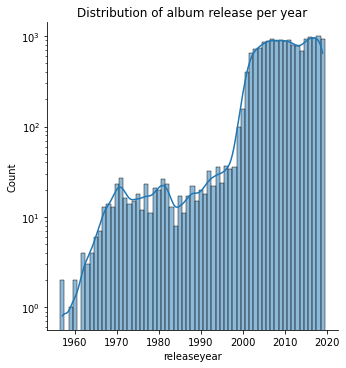

In [4]:
# 1.2 - Plot the distribution of album release years

# Calculate mean score per year as restore the result as dataframe
mean_score_per_year = df.groupby(["releaseyear"], as_index=False).agg({'score': 'mean'})
display(mean_score_per_year.head())

# Plot
sns.displot(df.releaseyear, bins=63, kde=True)
plt.title("Distribution of album release per year")
plt.yscale('log')

Text(0.5, 1.0, 'Average scores of albums per year')

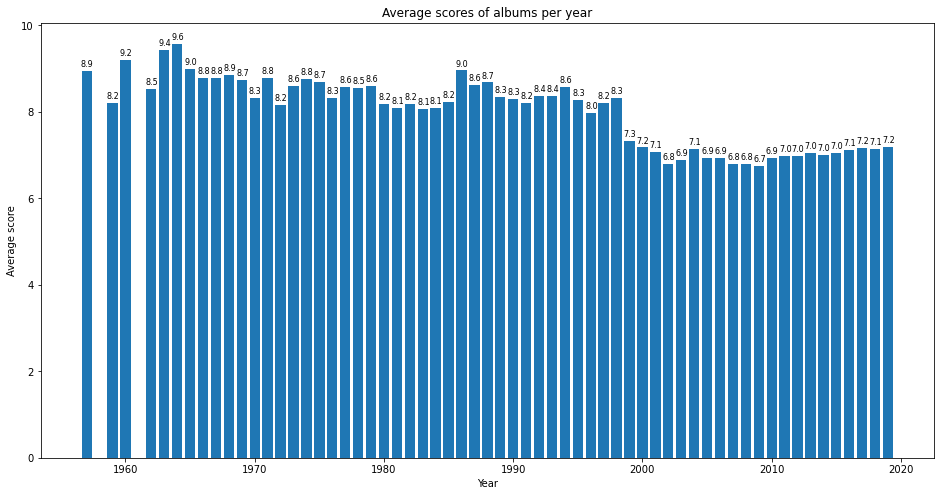

In [5]:
# 1.2 - Plot the average score per year

# Plot the distributions of average scores of albums per year
df_avg = df.groupby('releaseyear')['score'].mean()

plt.figure(figsize=(16, 8))
plt.bar(df_avg.index, df_avg)
for x,y in zip(df_avg.index, df_avg):
    plt.text(x+0.05,y+0.05,'%.1f' %y, ha='center',va='bottom', fontsize=8)
    
plt.xlabel('Year')
plt.ylabel('Average score')
plt.title('Average scores of albums per year')

In [6]:
# 1.3 - Calculate the mean, median, minimum value and maximum value for numerical columns

# Here we use 'descirbe' function as it will automatically neglect non-numerical columns
stats = df.describe().loc[['mean' , '50%', 'min', 'max'], :].rename({"50%": "median"})
stats

,score,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
mean,7.048596,0.512334,0.601276,5.216501,-9.283268,0.090742,0.301914,0.274748,0.196402,0.405268,120.326487
median,7.300000,0.511348,0.624722,5.230769,-8.444263,0.056665,0.228844,0.149363,0.174261,0.406288,120.397346
min,0.000000,-1.000000,-1.000000,-1.000000,-51.728750,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
max,10.000000,0.974000,0.999000,11.000000,4.078000,0.958000,0.996000,0.982000,0.978000,0.971000,215.972000


Due to the fact that the scale of column **tempo** is very different from the others, and there are negative values in the dataset, which means we cannot use log scale in the plot. In this case, we decided to standardise the numerical columns first before we plot it.

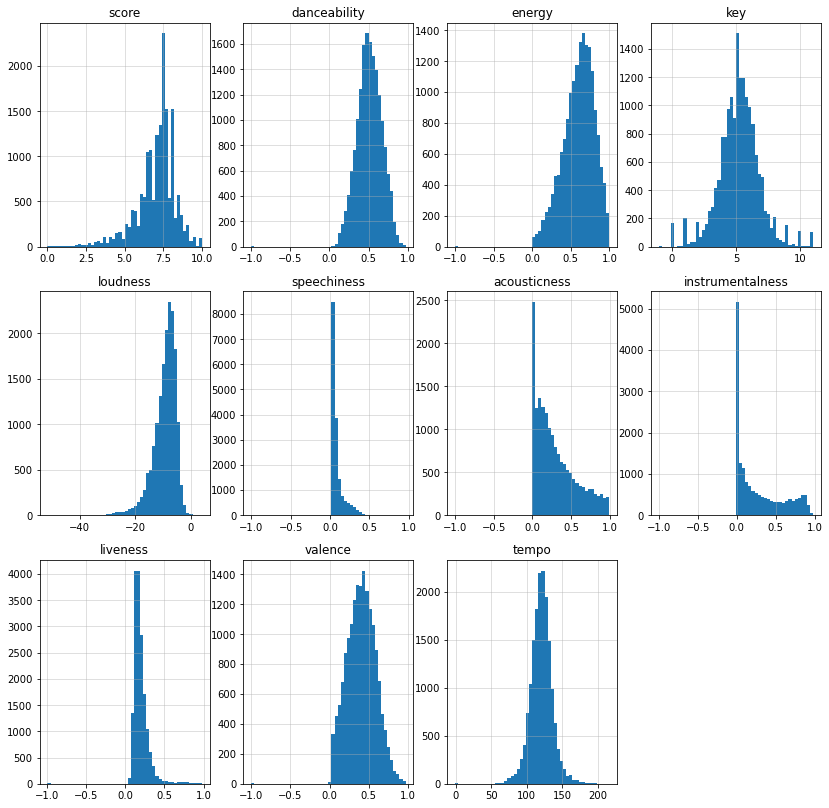

In [7]:
# 1.3 - Plot the distribution for all the numerical columns


# Have multiple subplots in the same image
fig, axs = plt.subplots(nrows=3, ncols=4, sharex=False, sharey=False, figsize=(14,14))


for axe, col in zip(axs.flat, stats.columns):
    df[col].hist(ax=axe, grid = True, bins=50)
    axe.set_title(col)
    axe.grid(which='major', alpha=0.5)

# Remove the empty plot
fig.delaxes(axs[2][3])

In [8]:
# 1.4 - list how many different values here are in each column

categorical_cols = list(set(df.columns) - set(stats.columns))
categorical_features = df[categorical_cols]
categorical_features.nunique()

recordlabel      3032
releaseyear        61
album           16183
reviewdate       4876
genre              10
reviewauthor      554
artist           7892
dtype: int64

As can be seen from the statistics above, the only feature that is likely to have less than 10 distinct values is **genre**, thus we will validate whether there is something like "none" be treated as one distinct value. If there is, we will print the truly distinct values under this category.

In [9]:
# 1.4 - Print distinct values for category with less than 10 distinct values

if "none" in categorical_features.genre.unique():
    print([x for x in categorical_features.genre.unique() if x != "none"])

['Electronic', 'Folk/Country', 'Rock', 'Rap', 'Global', 'Experimental', 'Metal', 'Pop/R&B', 'Jazz']


In [10]:
# 1.4 - Assign the value 'Other' for albums where the value is either 'none' or NaN for the genre column

print("Number of rows with value 'none' or NaN: {}".format(len( df.loc[(df.genre == 'none') | (df.genre.isnull())] )))
df.genre = df.genre.apply(lambda x: 'Other' if (x == 'none' or x == np.nan) else x)
print("Number of rows with value 'Other': {}".format(len(df[df.genre == "Other"])))

Number of rows with value 'none' or NaN: 11
Number of rows with value 'Other': 11


**Discussion 1.5**: 
1. Music reviews are unpredictable, often have strong dependencies on which reviewer is writing. This leads to imbalanced number of reviews for different genres and provocative or contrarian reviews.
2. Critics of Pitchfork state that some reviews are unreadable, some are under-edited, and some are "overly florid", leading to the problem of invalid reviews and scores in this dataset.
3. All albums are attributed to one of given 10 genres, this may not be representative for albums combining different styles. Besides, simply attribute all other styles to 'Others' may induce great feature inconsistency under this genre (for example, pure music, blues & classical). Also, the data itself is biased over the release years, with a heavy-tailed review distribution from 2000 to 2019. This means not up-to-date/popular music styles will not be weighted in balance with those popular ones.

#### **Task 2 (Pre-processing and pipeline code — 12 pts)**

Next, you decide to prepare the code that will help you in training your machine learning models. Also, you implement a simple baseline. For this task, **unless otherwise stated** you must implement functions yourself, instead of relying on `scikit-learn` (you can use `numpy` or `pandas`, though!).

1. For each possible value in the `genre` column, create a new column called `{genre}_onehot` (e.g., for `genre=jazz`, create `jazz_onehot`). Collectively, these new columns should "one hot-encode" the genre column—for instance, if for a given album the `genre` is filled with the value `jazz`, the `jazz_onehot` column should equal 1 and all other `{genre}_onehot` columns should equal 0. 

2. Create a function `numpy_helper(df, cols)` to obtain a `numpy.array` out of your `dataframe`. The function should receive a dataframe `df` with N rows and a list of M columns `cols`, and should return a `np.array` of dimension (NxM).

3. For each album, build an array of features `X` containing all genre-related one-hot features, and an array of outcomes `y` containing scores. Using the function [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with `random_state=123`, split the data into a train set containing 70% of all data, and a test set containing the remaining 30%.

4. Create your own baseline regressor. Using the training data (in the training stage), your regressor should estimate the average score for all albums. Then, for the test data (in the prediction stage), your classifier should always output the average score (computed on the training data).

5. Calculate the [coefficient of determination ($R^2$)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) of your baseline on the test data. **You are allowed to use the `sklearn` implementation here.**

6. **Discuss:** Your train-test split randomly selected 70% of all data for the training set. Why is this a problem for the broader task of predicting whether a future album will be successful or not?

---

In [11]:
# 2.1

# get_dummies does not have built-in implementation for postfix
# so we have to manually renaming these columns
genre_list = df['genre'].unique().tolist()
onehotmap = {'genre_{}'.format(genre):'{}_onehot'.format(genre) for genre in genre_list}

df_genre_onehot = pd.get_dummies(df, columns=['genre'])
df_genre_onehot.rename(columns=onehotmap, inplace=True)

df_genre_onehot.head()

,artist,album,reviewauthor,score,releaseyear,reviewdate,recordlabel,danceability,energy,key,...,Electronic_onehot,Experimental_onehot,Folk/Country_onehot,Global_onehot,Jazz_onehot,Metal_onehot,Other_onehot,Pop/R&B_onehot,Rap_onehot,Rock_onehot
0,Studio 1,Studio 1,Andy Battaglia,8.5,2009,2009-02-18,Studio,0.511917,0.499667,5.250000,...,1,0,0,0,0,0,0,0,0,0
1,John Fahey,The Great Santa Barbara Oil Slick,Mark Richardson,8.2,2005,2005-02-13,Water,0.369765,0.325412,4.470588,...,0,0,1,0,0,0,0,0,0,0
2,Reigning Sound,Too Much Guitar,Stephen M. Deusner,8.3,2004,2004-08-19,In the Red,0.253943,0.912857,4.428571,...,1,0,0,0,0,0,0,0,0,0
3,The Red Thread,After the Last,Chris Dahlen,7.3,2003,2003-07-17,Badman,0.425400,0.433474,5.700000,...,0,0,0,0,0,0,0,0,0,1
4,Mac Miller,Swimming,Evan Rytlewski,7.5,2018,2018-08-03,Warner Bros.,0.624846,0.438154,4.153846,...,0,0,0,0,0,0,0,0,1,0


In [12]:
# 2.2

def numpy_helper(df, cols):
    # obtain a numpy.array out of the given columns of the dataframe
    return df[cols].to_numpy()


In [13]:
# 2.3

# Select genre-related onehot features
genre_cols = df_genre_onehot.columns[df_genre_onehot.columns.str.contains("onehot")].to_list()

# build an array of features X containing all genre-related one-hot features
X = numpy_helper(df_genre_onehot, genre_cols)
print("Top five feature vectors :\n {} \n".format(X[:5]))

# and an array of label y 
y = numpy_helper(df_genre_onehot, "score")
print("Top five labels :\n {} \n".format(y[:5]))

trainX, testX, trainY, testY = train_test_split(X, y, train_size=0.7, random_state=123)

print("Number of training feature vectors: {}".format(len(trainX)))
print("Number of training labels: {}".format(len(trainY)))

print("Number of testing feature vectors: {}".format(len(testX)))
print("Number of testing labels: {}".format(len(testY)))

Top five feature vectors :
 [[1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0]] 

Top five labels :
 [8.5 8.2 8.3 7.3 7.5] 

Number of training feature vectors: 11716
Number of training labels: 11716
Number of testing feature vectors: 5022
Number of testing labels: 5022


In [14]:
# 2.4 - Implement linear regression with gradient descent

def compute_gradient(y, tx, w):
    e_term = y - tx.dot(w)
    gradient = -tx.T.dot(e_term)/len(e_term)
    return gradient


# Compute MSE loss
def compute_loss(y, tx, w):
    e_term = y - tx.dot(w)
    loss = 1/2 * np.mean(e_term ** 2)
    return loss


def gradient_descent(y, tx, initial_w, max_iters, gamma):
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w

    for n_iter in range(max_iters):
        grad = compute_gradient(y, tx, w)
        loss = compute_loss(y, tx, w)

        # update w by gradient
        w = w - gamma * grad

        # store w and loss
        ws.append(w)
        losses.append(loss)

        if (n_iter + 1) % 1000 == 0:
            print("Gradient Descent(iter:{bi}): loss={l}".format(
                  bi=n_iter+1, l=loss))

    return losses, ws

In [15]:
# 2.4 - output the average score for test data

# Train model
# Define hyper-parameters
MAX_ITER = 40000
GAMMA = 0.8

# Initialization
w_initial = np.zeros((trainX.shape[1], 1))

# Initialization
w_initial = np.zeros((trainX.shape[1], 1))

# Reshape trainY to 2D array
trainY = trainY.reshape(-1, 1)

# Linear regression by gradient descent, after 40000 iterations near convergence
loss, weight = gradient_descent(trainY, trainX, w_initial, MAX_ITER, GAMMA)

# The result of trained weights corresponds to the expectation score for each genre
# Here we only take the weight vector from the last iteration
y_pred = np.dot(testX, weight[-1])

Gradient Descent(iter:1000): loss=0.7778346898881559
Gradient Descent(iter:2000): loss=0.7733768561750619
Gradient Descent(iter:3000): loss=0.7718823036617527
Gradient Descent(iter:4000): loss=0.7713812262703398
Gradient Descent(iter:5000): loss=0.7712132304656075
Gradient Descent(iter:6000): loss=0.771156906650382
Gradient Descent(iter:7000): loss=0.7711380230111946
Gradient Descent(iter:8000): loss=0.7711316919090216
Gradient Descent(iter:9000): loss=0.7711295692856055
Gradient Descent(iter:10000): loss=0.7711288576353992
Gradient Descent(iter:11000): loss=0.7711286190410201
Gradient Descent(iter:12000): loss=0.771128539047679
Gradient Descent(iter:13000): loss=0.7711285122283772
Gradient Descent(iter:14000): loss=0.7711285032366921
Gradient Descent(iter:15000): loss=0.7711285002220571
Gradient Descent(iter:16000): loss=0.7711284992113431
Gradient Descent(iter:17000): loss=0.7711284988724816
Gradient Descent(iter:18000): loss=0.7711284987588719
Gradient Descent(iter:19000): loss=0.77

In [17]:
# 2.5

r2_score(testY, y_pred)

0.014316755584446783

**Discussion 2.6**: Considering the imbalanced genre distribution and the total number of reviews, 70% is far not enough to include balanced reviews for genres. Considering the randomness of splitting, some reviews of certain genres (e.g. Others) may not even be included in the training set. Besides the imbalance problem, many data will not be used for training for a 70%:30% splitting strategy.


**Task 3 (Regression — 14 pts)**

Finally, you get down to business and train your regression models.

1. Build a Linear Regression model (use `sklearn`) that predicts the outcome `score` using the features "releaseyear",  "key", "acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "valence", "tempo" and the one-hot encoded genre-related columns.  Using a 70/30 train-test split similar to what you did in task two (hereinafter referred to as "the random split", use the same random seed, `random_state=123`), report the $R^2$ for the testing set.

2. Create an alternate train-test split (hereinafter referred to as "the longitudinal split") where you train with data from albums released before 2000 and test with data from 2003 and after. Report the $R^2$ for the testing set using the same model you developed for the previous question. **Discuss:** give the correct interpretation of $R^2$ value for the longitudinal split.

3. For a given entry $X$ your model outputs a predicted score $Y'$. The difference between the real score $Y$ and the predicted score $Y'$ is called the "residual". Considering the model trained in 3.2, plot the distribution of your residuals for the test set. Additionally, estimate what is the probability that your score prediction (from 3.2) is off by more than 2-points? Provide bootstrapped confidence intervals for your answer.

4. Experiment with training a different regressor, a Gradient Boosting Regressor. This regressor is related to the Boosted decision trees that you have seen in class. This model performs extremely well for a variety of tasks and is often used in machine learning competitions for tabular data (e.g., on Kaggle). Train the regressor using the longitudinal split and the same features as in 3.2, use the default hyperparameters. Report the $R^2$ for the testing set. 

5. **Discuss:** Hypothesize a reason for the difference in performance between the Linear regression and the Gradient Boosting Regressor.

---

In [18]:
# 3.1

selected_features = ["releaseyear", "key", "acousticness", "danceability", "energy", \
                     "instrumentalness", "liveness", "loudness", "speechiness", "valence", "tempo"] + genre_cols

# We only need features, label can be reused from the above task
X = numpy_helper(df_genre_onehot, selected_features)

trainX, testX, trainY, testY = train_test_split(X, y, train_size=0.7, random_state=123)

reg = LinearRegression().fit(trainX, trainY)
predict_score = np.round_(reg.predict(testX), decimals=1)

print("R2 score for testing set with random train test split: {}".format(r2_score(testY, predict_score)))

R2 score for testing set with random train test split: 0.044746457761770886


In [19]:
# 3.2

train = df_genre_onehot[df_genre_onehot.releaseyear.astype(int) < 2000]
test = df_genre_onehot[df_genre_onehot.releaseyear.astype(int) >= 2003]

print("Training set size: {}".format(len(train)))
print("Testing set size: {}".format(len(test)))

trainX, trainY = train[selected_features], train.score
testX, testY = test[selected_features], test.score

reg = LinearRegression().fit(trainX, trainY)
predict_score = np.round_(reg.predict(testX), decimals=1)

print("R2 score for testing set with the longitudinal split and linear regressor: {}".format(r2_score(testY, predict_score)))


Training set size: 778
Testing set size: 14752
R2 score for testing set with the longitudinal split and linear regressor: -0.2839856861117138


**Discussion 3.2**: Here the  𝑅2  score is negative, this means the trained model is not following the trend of data correctly, or it can be interpreted as the model is "wrong enough". The longitudinal split only have 783 training samples, whereas 14769 samples are used for testing. In this case, the training instances are insufficient, thus the  trained model is significantly underfitted and of high bias and high variance. Besides, previous analysis shows a higher average score for earlier reviews. Thus the model trained on this training split cannot have a good representation of the whole dataset.

Text(0.5, 1.0, 'Distribution of residual for testing data')

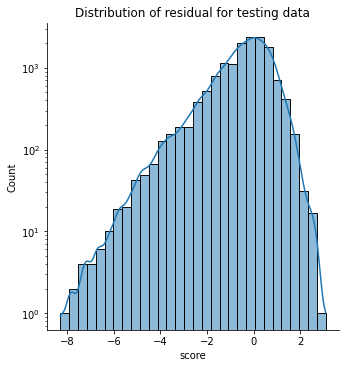

In [20]:
# 3.3 - Plot the distribution of residual for testing data

# The difference between the real score  𝑌  and the predicted score  𝑌′  is called the "residual".
residual = testY - predict_score

sns.displot(residual, bins=30, kde=True)
plt.yscale('log')
plt.title('Distribution of residual for testing data')

In [21]:
# 3.3 - estimate the probability of score prediction is off by more than 2-points

over_two_proba = sum(residual*residual > 4) / len(residual)

print("The estimated probability for score prediction off by more than 2-points: {}".format(over_two_proba))

The estimated probability for score prediction off by more than 2-points: 0.1052738611713666


In [22]:
# 3.3 - Bootstrapped Confidence Intervals

NBR_SAMPLE = 300
SAMPLE_SIZE = 2000

def bootstrapped_CI(t_label, p_label, nbr_draws=NBR_SAMPLE, draw_size=SAMPLE_SIZE):
    
    # Initiate an empty list to store probas
    probas = np.zeros(nbr_draws)
    
    # Concat true label with prediction to perform random sampling
    label_concat = np.stack((t_label, p_label), axis=-1)
    
    for n in range(nbr_draws):
        # Select indices randomly with replacement
        indices   = np.random.randint(0, len(label_concat), draw_size)
        
        # Measure the squared distance
        probas[n] = sum(np.square(label_concat[indices, 0] - label_concat[indices, 1]) > 4) / draw_size
    
    return [np.nanpercentile(probas, 5),np.nanpercentile(probas, 95)]

bci = bootstrapped_CI(testY, predict_score)
print("90% Bootstrapped Confidence interval for {} samples with size {}: {}".format(NBR_SAMPLE, SAMPLE_SIZE, bci))

90% Bootstrapped Confidence interval for 300 samples with size 2000: [0.0935, 0.11702500000000002]


In [23]:
# 3.4 

reg = GradientBoostingRegressor().fit(trainX, trainY)
predict_score_gbr = np.round_(reg.predict(testX), decimals=1)

print("R2 score for testing set with gradient boosting regressor and the longitudinal split: {}"\
      .format(r2_score(testY, predict_score_gbr)))

R2 score for testing set with gradient boosting regressor and the longitudinal split: -0.48105613658749036


**Discussion 3.5**: Gradient boosting regressor tends to easily overfit the training data. Given the number of training samples is too small, GBR will perform even worse compared to LR.

**Task 4 (Are we solving the correct problem? — 16 pts)**

All your efforts so far have assumed that decisions are taken at the "album" level, which is often not the case for bands with multiple albums. In those cases, it could be interesting to predict what is the success of a given band album given the features of the album **and of previous albums**.

1. Create a new dataframe that contains one row per band with more than 1 album. This dataframe should have the same columns as the data provided to you, considering the latest album of the respective band (note that this is determined by the release year of the album, not the date when it was reviewed). Additionally, for each feature considered in Task 3.1 (including the one-hot encoded features), create an additional column post-fixed with `_previous` (e.g., `danceability_previous`). These columns should contain the average values for all of the band's previous albums. Also, create a column `score_previous` with the average score of previous albums. Print the number of rows in the dataframe as well as the name of the columns.

2. Train a Gradient Boosting Regressor considering all features created in Task 4.1 (note that `score` is the outcome and everything else is a feature, including `score_previous`). Use the 70/30 random train-test split, the default hyperparameters, and report the $R^2$ for the testing set. 

3. Can hyperparameter tuning improve your model? Write modular code (i.e., a function) to divide your training data into $N$ folds and perform cross-validation. Experiment tuning two hyperparameters of the Gradient Boosting Regressor: `n_estimators` and `learning_rate`. For each possible combination of the two hyperparameters (see below for the range of values that you should try for each hyperparameter), train your model in a cross-validation setup with $N=20$ folds. Report the mean  $R^2$ along with the 90% CI for each scenario. 
    - n_estimators $ \in  \{ 100, 200, 300, 400\}$
    - learning_rate $ \in  \{ 0.1, 0.05, 0.01\}$.
 
 With the best hyperparameters obtained, train your model with the entire training set and report the $R^2$ on the testing set.
 
4. **Discuss:** How do these results compare with the previous setup (the scenario considered in **Task 3.4**)? Point out two reasons why it is hard to compare the results obtained in 4.3 and 3.4 at face value? How would you fairly compare the two different setups?

---

In [24]:
# 4.1 - Create a new dataframe that contains one row per band with more than 1 album and keep the latest album

# Select rows with more than one occurrence
# Sort the dataframe in descending order by column - artist, releaseyear, reviewdate
df_multi_occurrence = df_genre_onehot.groupby('artist')\
                                     .filter(lambda x : x['artist'].shape[0] > 1)\
                                     .sort_values(by=['artist', 'releaseyear', 'reviewdate'], ascending=False)



# We have already sort the dataframe in descending order
# Thus we only need to drop duplicates in subset "artist" and keep the first occurrence only
df_latest = df_multi_occurrence.drop_duplicates(subset=["artist"], keep='first')
df_latest.head()

,artist,album,reviewauthor,score,releaseyear,reviewdate,recordlabel,danceability,energy,key,...,Electronic_onehot,Experimental_onehot,Folk/Country_onehot,Global_onehot,Jazz_onehot,Metal_onehot,Other_onehot,Pop/R&B_onehot,Rap_onehot,Rock_onehot
14089,Ólafur Arnalds,Now I Am Winter,Brian Howe,5.5,2013,2013-04-09,Mercury,0.468375,0.215296,3.950000,...,0,0,0,0,0,0,0,0,0,1
213,Âme,Dream House,Daniel Martin-McCormick,4.8,2018,2018-06-02,Innervisions,0.660727,0.565727,4.727273,...,1,0,0,0,0,0,0,0,0,0
7397,µ-Ziq,Challenge Me Foolish,Andy Beta,5.8,2018,2018-04-16,Planet Mu,0.547071,0.598143,4.714286,...,1,0,0,0,0,0,0,0,0,0
9843,"¡Forward, Russia!",Life Processes,Mike Orme,6.4,2008,2008-07-22,Mute,0.393545,0.751182,5.000000,...,1,0,0,0,0,0,0,0,0,0
11403,yMusic,Balance Problems,Jeremy D. Larson,7.6,2014,2014-10-01,New Amsterdam,0.377375,0.194500,5.875000,...,0,0,0,0,0,0,0,1,0,0


In [25]:
# 4.1 - Create another dataframe containing average value for the previous albums to facilitate later use

# Select previous albums by index
df_previous = df_multi_occurrence.loc[list(set(df_multi_occurrence.index) - set(df_latest.index)),:]\
                                 .sort_values(by=['artist', 'releaseyear', 'reviewdate'], ascending=False)
display(df_previous.head())


# Aggregrate selected features by mean
selected_features.append('score')

df_previous_avg = df_previous.groupby(["artist"], as_index=False)[selected_features]\
                             .agg('mean')\
                             .sort_values(by=['artist'], ascending=False)\
                             .reset_index(drop=True)
                                    
display(df_previous_avg)

# Create new columns by merging the latest and previous dataframe
df_new = df_latest.merge(df_previous_avg, left_on='artist', right_on='artist', suffixes=("", "_previous"))
display(df_new.head())

# Print number of rows and column names
print("Number of rows in the dataframe: {}".format(len(df_new)))
print("Columns name: {}".format(df_new.columns))

,artist,album,reviewauthor,score,releaseyear,reviewdate,recordlabel,danceability,energy,key,...,Electronic_onehot,Experimental_onehot,Folk/Country_onehot,Global_onehot,Jazz_onehot,Metal_onehot,Other_onehot,Pop/R&B_onehot,Rap_onehot,Rock_onehot
15915,Ólafur Arnalds,Living Room Songs,Joe Colly,4.5,2012,2012-02-16,Erased Tapes,0.312857,0.131371,4.714286,...,0,0,0,0,0,0,0,0,0,1
2494,Ólafur Arnalds,...And They Have Escaped the Weight of Darkness,Brian Howe,7.0,2010,2010-06-10,Erased Tapes,0.261889,0.148100,1.444444,...,0,0,0,0,0,0,0,0,0,1
7754,Ólafur Arnalds,Found Songs,Brian Howe,6.3,2009,2010-02-16,Erased Tapes,0.319143,0.182857,6.000000,...,0,0,0,0,0,0,0,0,0,1
3870,Âme,...Mixing,Tim Finney,7.2,2007,2007-05-23,Sonar Kollektiv,0.658000,0.657400,1.800000,...,1,0,0,0,0,0,0,0,0,0
8486,µ-Ziq,Somerset Avenue Tracks (1992-1995),Miles Raymer,8.0,2013,2013-08-07,Planet Mu,0.485250,0.763330,5.650000,...,1,0,0,0,0,0,0,0,0,0


,artist,key,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,valence,...,Experimental_onehot,Folk/Country_onehot,Global_onehot,Jazz_onehot,Metal_onehot,Other_onehot,Pop/R&B_onehot,Rap_onehot,Rock_onehot,score
0,Ólafur Arnalds,4.052910,0.947265,0.297963,0.154110,0.775249,0.114343,-17.120619,0.039986,0.122328,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.933333
1,Âme,1.800000,0.326800,0.658000,0.657400,0.000006,0.430000,-6.551800,0.131600,0.579800,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.200000
2,µ-Ziq,5.577778,0.189885,0.476897,0.767860,0.559323,0.175586,-8.761044,0.141245,0.375307,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.666667
3,"¡Forward, Russia!",4.181818,0.003561,0.416273,0.922364,0.055212,0.237636,-3.814273,0.068855,0.440809,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.200000
4,yMusic,5.285714,0.971000,0.372143,0.183414,0.667857,0.103986,-15.232000,0.040057,0.213043,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3559,13 & God,4.500000,0.477700,0.626600,0.572700,0.433760,0.161650,-11.962400,0.064900,0.190610,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.100000
3560,03 Greedo,4.704545,0.136049,0.723779,0.529129,0.003679,0.171741,-7.953956,0.160465,0.345698,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.866667
3561,...And You Will Know Us by the Trail of Dead,4.640999,0.222795,0.452275,0.617621,0.200996,0.201938,-7.376548,0.058137,0.322370,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7.170000
3562,(Sandy) Alex G,6.071429,0.283422,0.461143,0.588929,0.313242,0.222736,-7.042714,0.049843,0.462714,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.400000


,artist,album,reviewauthor,score,releaseyear,reviewdate,recordlabel,danceability,energy,key,...,Experimental_onehot_previous,Folk/Country_onehot_previous,Global_onehot_previous,Jazz_onehot_previous,Metal_onehot_previous,Other_onehot_previous,Pop/R&B_onehot_previous,Rap_onehot_previous,Rock_onehot_previous,score_previous
0,Ólafur Arnalds,Now I Am Winter,Brian Howe,5.5,2013,2013-04-09,Mercury,0.468375,0.215296,3.950000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5.933333
1,Âme,Dream House,Daniel Martin-McCormick,4.8,2018,2018-06-02,Innervisions,0.660727,0.565727,4.727273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.200000
2,µ-Ziq,Challenge Me Foolish,Andy Beta,5.8,2018,2018-04-16,Planet Mu,0.547071,0.598143,4.714286,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.666667
3,"¡Forward, Russia!",Life Processes,Mike Orme,6.4,2008,2008-07-22,Mute,0.393545,0.751182,5.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.200000
4,yMusic,Balance Problems,Jeremy D. Larson,7.6,2014,2014-10-01,New Amsterdam,0.377375,0.194500,5.875000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.700000


Number of rows in the dataframe: 3564
Columns name: Index(['artist', 'album', 'reviewauthor', 'score', 'releaseyear', 'reviewdate',
       'recordlabel', 'danceability', 'energy', 'key', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'Electronic_onehot', 'Experimental_onehot',
       'Folk/Country_onehot', 'Global_onehot', 'Jazz_onehot', 'Metal_onehot',
       'Other_onehot', 'Pop/R&B_onehot', 'Rap_onehot', 'Rock_onehot',
       'key_previous', 'acousticness_previous', 'danceability_previous',
       'energy_previous', 'instrumentalness_previous', 'liveness_previous',
       'loudness_previous', 'speechiness_previous', 'valence_previous',
       'tempo_previous', 'Electronic_onehot_previous',
       'Experimental_onehot_previous', 'Folk/Country_onehot_previous',
       'Global_onehot_previous', 'Jazz_onehot_previous',
       'Metal_onehot_previous', 'Other_onehot_previous',
       'Pop/R&B_onehot_previous', 'Rap_onehot_previ

In [26]:
# 4.2

# Note: variables overwritten here

y = df_new.score

X = df_new.drop(columns=['score', 'artist', 'album', 'recordlabel', 'reviewauthor', 'reviewdate'])

trainX, testX, trainY, testY = train_test_split(X, y, train_size=0.7, random_state=123)

reg = GradientBoostingRegressor().fit(trainX, trainY)
predict_score_all = np.round_(reg.predict(testX), decimals=1)

print("R2 score for testing set with all the numerical features in task 4.2: {}"\
      .format(r2_score(testY, predict_score_all)))

R2 score for testing set with all the numerical features in task 4.2: 0.246260437134322


In [27]:
# 4.3 - Cross Validation Implementation

# to divide your training data into  𝑁  folds and perform cross-validation. 
# Experiment tuning two hyperparameters of the Gradient Boosting Regressor: n_estimators and learning_rate. 
# For each possible combination of the two hyperparameters, 
# train your model in a cross-validation setup with 𝑁=20 folds. Report the mean  𝑅2  along with the 90% CI for each scenario.

N_ESTIMATOR   = [100, 200, 300, 400] 
LEARNING_RATE = [0.1, 0.05, 0.01]

def cross_validation(features, label, nbr_fold=20, estimators=N_ESTIMATOR, lambda_=LEARNING_RATE):
    # Define the split 
    kf = KFold(n_splits=nbr_fold, random_state=42, shuffle=True)  
    r_square_list = []
    hyper_list = []
    
    # Cross Validation
    for e in estimators:
        for l in lambda_:
            
            # Internal array to store r2 
            r_square = np.zeros(nbr_fold)
            loss = np.zeros(nbr_fold)
            reg = GradientBoostingRegressor(n_estimators=e, learning_rate=l)
            
            for idx, (train_index, test_index) in enumerate(kf.split(features)):

                train_features = features.loc[train_index, :]
                train_label = label.loc[train_index]

                test_features = features.loc[test_index, :]
                test_label = label.loc[test_index]

                reg.fit(train_features, train_label)
                pred = np.round_(reg.predict(test_features), decimals=1)
                
                r_square[idx] = r2_score(test_label, pred)
            
            avg_r_sqaure = np.mean(r_square)
            
            r_square_list.append(avg_r_sqaure)
            hyper_list.append([e, l])
            
            # 90% Confidence Interval
            print("Number of estimator: {}".format(e))
            print("Learning rate: {}".format(l))
            print("Mean R2 over {} folds: {}".format(nbr_fold, avg_r_sqaure))
            print("90% Confidence interval: [{}, {}]".format(np.sort(r_square)[1], np.sort(r_square)[18]))
            print()
    
    best_r2 = max(r_square_list)
    best_r2_idx = r_square_list.index(best_r2)
    
    return hyper_list[best_r2_idx], best_r2

In [61]:
# 4.3 Run cross validation to select the best hyperparameters

best_hyper, best_r2 = cross_validation(trn_estimators=et_index(drop=True), trainY.reset_index(drop=True))

print("The optimal number of estimator: {}".format(best_hyper[0]))
print("The optimal learning rate: {}".format(best_hyper[1]))
print("R Sqaure calculated using the optimal hyperparameters {}".format(best_r2))

Number of estimator: 100
Learning rate: 0.1
Mean R2 over 20 folds: 0.14542360046749575
90% Confidence interval: [-0.05049736679919481, 0.29738835121204166]

Number of estimator: 100
Learning rate: 0.05
Mean R2 over 20 folds: 0.16461225952237052
90% Confidence interval: [-0.0233238372074005, 0.298633258159397]

Number of estimator: 100
Learning rate: 0.01
Mean R2 over 20 folds: 0.14183442551171455
90% Confidence interval: [0.04446513853332301, 0.20823918148198162]

Number of estimator: 200
Learning rate: 0.1
Mean R2 over 20 folds: 0.12031411907435414
90% Confidence interval: [-0.07348792641399493, 0.2924778849196952]

Number of estimator: 200
Learning rate: 0.05
Mean R2 over 20 folds: 0.15376103518906634
90% Confidence interval: [-0.043544651338607965, 0.28108192395680787]

Number of estimator: 200
Learning rate: 0.01
Mean R2 over 20 folds: 0.16170418296972638
90% Confidence interval: [0.02633013904029169, 0.2531249930838504]

Number of estimator: 300
Learning rate: 0.1
Mean R2 over 20 

In [62]:
# 4.3 - Train the model with the entire training set and report the R2

reg = GradientBoostingRegressor(n_estimators=best_hyper[0], learning_rate=best_hyper[1])
reg.fit(trainX.reset_index(drop=True), trainY.reset_index(drop=True))
pred = np.round_(reg.predict(testX), decimals=1)
r2_score(testY, pred)

0.25492526261759574

**Discussion 4.4**: Comparing the $R^2$-score between 4.3 and 3.4, the model performance significantly improves since the result in 4.3 turns to positive and reaches approximately 0.255. However, it is hard to directly compare the results given the following reasons:

1. Number of samples in training/test set in two setups are different. Although the splitting strategy remains 70%:30%, in 4.3 both training and test set is smaller since we discard some original features and create statistical (e.g. mean of previous) features for training and testing. However, real data trend may be affected or even modified in this case.
2. During the training process, we fine-tune the hyper-parameters to obtain an 'optimal' training result. However, in 3.4 we use default parameters to get the result instead. This will add to the difference of model performance ($R^2$ score).

To fairly compare the results, we would first compare the model performance both under fine-tuned parameter set. Also, we will consider pruning the training and test set so that both models are trained and tested on equal-scaled datasets.

## Part 2: Second Album Syndrome

Your second project at *Piccardi Music* is to shed light on one of the business's oldest enigmas: the "second album syndrome." In a nutshell, the "second album syndrome" is a theory that states that the second album of a band always sucks. ([Related read](https://tvtropes.org/pmwiki/pmwiki.php/Main/SophomoreSlump))

Assume—for the purpose of this task—that the Pitchfork data contains all albums for all artists it covers (even though this might not be true in reality).

**Task 5 (Preliminary analyses — 8 pts)**

You begin by carrying out some preliminary data processing and analyses.

1. Create a new dataframe (from the original data with duplicates dropped, the same as you obtained after finishing Task 1.1) containing only albums from artists with two or more albums and where the release year is not empty.
2. Create a new column `album_number` which indicates how many albums the artist has produced before this one (before the second album, the artist has already produced one album).
3. Calculate the mean and the standard error fo the mean of the scores of the first and second albums in the dataset. Additionally, plot the two distributions. 
4. Use an appropriate method to determine if the difference in means of 1st and 2nd albums is statistically significant?
5. **Discuss:** Do these analyses suggest that the "second album syndrome" exists?

---

In [28]:
# 5.1

PATH = "./data/pitchfork.csv.gz"
df = pd.read_csv(PATH, compression="gzip")

df.reviewdate = \
df.reviewdate.apply(lambda x: "%d/%02d/%02d" % (parser.parse(x).year,
                                                parser.parse(x).month,
                                                parser.parse(x).day))

df.reviewdate = pd.to_datetime(df.reviewdate)

# Drop duplicates
df.drop_duplicates(subset=['artist', 'album'], keep='first', inplace=True)

# Filter albums where artists have two or more albums
df = df.groupby('artist').filter(lambda x : x['artist'].shape[0] > 1)

# Filter albums where releaseyear is not empty
df = df[df.releaseyear.notnull()]

df

,artist,album,reviewauthor,score,releaseyear,reviewdate,recordlabel,genre,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
1,John Fahey,The Great Santa Barbara Oil Slick,Mark Richardson,8.2,2005.0,2005-02-13,Water,Folk/Country,0.369765,0.325412,4.470588,-19.153824,0.148624,0.647053,0.559133,0.527782,0.179465,107.622647
2,Reigning Sound,Too Much Guitar,Stephen M. Deusner,8.3,2004.0,2004-08-19,In the Red,Electronic,0.253943,0.912857,4.428571,-1.089500,0.055500,0.000253,0.751214,0.199071,0.552786,133.895500
4,Mac Miller,Swimming,Evan Rytlewski,7.5,2018.0,2018-08-03,Warner Bros.,Rap,0.624846,0.438154,4.153846,-9.456077,0.170246,0.652462,0.012819,0.121131,0.281138,122.121308
5,French Kicks,Swimming,Roque Strew,7.6,2008.0,2008-08-27,Vagrant,Electronic,0.624846,0.438154,4.153846,-9.456077,0.170246,0.652462,0.012819,0.121131,0.281138,122.121308
6,Jessica Lea Mayfield,With Blasphemy So Heartfelt,Stephen M. Deusner,8.2,2008.0,2008-11-11,Polymer,Rock,0.447583,0.399083,6.500000,-8.402000,0.032267,0.694750,0.004033,0.123142,0.237933,111.549917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16768,Morrissey,California Son,Ben Hewitt,5.9,2019.0,2019-05-25,none,Rock,0.480417,0.657000,4.083333,-5.798833,0.052375,0.167543,0.003680,0.133358,0.404542,125.641000
16769,Don Cherry,Brown Rice,Andy Beta,9.2,2019.0,2019-05-25,none,Jazz,0.624000,0.579000,7.000000,-8.389000,0.161000,0.348000,0.000032,0.204000,0.418000,182.968000
16772,Flying Lotus,Flamagra,Philip Sherburne,7.8,2019.0,2019-05-24,none,Electronic,0.536750,0.652050,5.350000,-8.583750,0.134820,0.215916,0.519892,0.192075,0.353705,124.988200
16773,YG,4REAL 4REAL,Sheldon Pearce,7.2,2019.0,2019-05-24,none,Rap,0.815429,0.556929,4.785714,-6.327643,0.259721,0.186476,0.000848,0.244586,0.361850,115.455857


In [29]:
# 5.2

# Sort the dataframe by release year and reviewdate in ascending order in each artist group
# Use cumcount to accumulate the occurrence
album_number = df.sort_values(['artist','releaseyear', 'reviewdate'],ascending=True).groupby(["artist"]).cumcount()

# Insert the column
df["album_number"] = album_number

# Display the result more intuitively
df.sort_values(['artist','releaseyear', 'reviewdate'], ascending=True).head(10)

,artist,album,reviewauthor,score,releaseyear,reviewdate,recordlabel,genre,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,album_number
7411,!!!,Split EP,Dominique Leone,6.0,1999.0,2004-02-12,GSL,Rock,0.470000,0.909500,6.000000,-4.112000,0.095600,0.000449,0.000000,0.177500,0.596500,97.046500,0
6891,!!!,Louden Up Now,Nick Sylvester,7.0,2004.0,2004-06-07,Touch and Go,Rock,0.808273,0.751636,6.818182,-7.082636,0.080591,0.116632,0.400204,0.159191,0.692364,119.974091,1
10517,!!!,Myth Takes,Brian Howe,8.0,2007.0,2007-03-02,Warp,Rock,0.646500,0.831800,5.400000,-6.939000,0.069290,0.091973,0.254866,0.233740,0.561200,116.136200,2
10053,!!!,"Strange Weather, Isn't It?",Larry Fitzmaurice,6.9,2010.0,2010-08-20,Warp,Rock,0.711889,0.881778,4.555556,-6.234556,0.047756,0.050500,0.236144,0.241333,0.763889,117.525000,3
2397,!!!,Thr!!!er,Brian Howe,6.0,2013.0,2013-04-30,Warp,Rock,0.778222,0.798444,5.666667,-6.810778,0.060756,0.032423,0.076008,0.161244,0.808111,117.911111,4
14646,!!!,As If,Cameron Cook,6.9,2015.0,2015-10-21,Warp,Rock,0.789818,0.772818,5.727273,-6.133909,0.081027,0.090824,0.111889,0.119209,0.660273,122.090000,5
472,!!!,Shake the Shudder,Stuart Berman,7.3,2017.0,2017-05-24,Warp,Rock,0.712667,0.773917,4.750000,-7.880500,0.096825,0.106212,0.207607,0.254258,0.693833,122.010583,6
16478,!!!,Wallop,Jesse Dorris,7.2,2019.0,2019-09-07,none,Rock,0.745643,0.737857,5.357143,-8.632500,0.127257,0.098557,0.176297,0.183271,0.529571,120.037500,7
14343,(Sandy) Alex G,Rocket,Ian Cohen,8.4,2017.0,2017-05-19,Domino,Rock,0.461143,0.588929,6.071429,-7.042714,0.049843,0.283422,0.313242,0.222736,0.462714,128.357714,0
16450,(Sandy) Alex G,House of Sugar,Anna Gaca,8.6,2019.0,2019-09-16,none,Rock,0.494308,0.639538,4.307692,-5.604154,0.033746,0.255131,0.289322,0.163469,0.421562,109.091385,1


In [30]:
# 5.3 - Calculate the mean and the standard error for the mean of the scores of the first and second albums in the dataset. 

album_fst_snd = df[(df.album_number == 0) | (df.album_number == 1)]

means = album_fst_snd.groupby("album_number")\
                     .agg({'score':['sem','mean']})\
                     .rename({0: "First Album", 1: "Second Album"})

means

score          
                   sem      mean
album_number                    
First Album   0.020686  7.303002
Second Album  0.021327  7.038468

/Users/xuyixuan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/xuyixuan/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


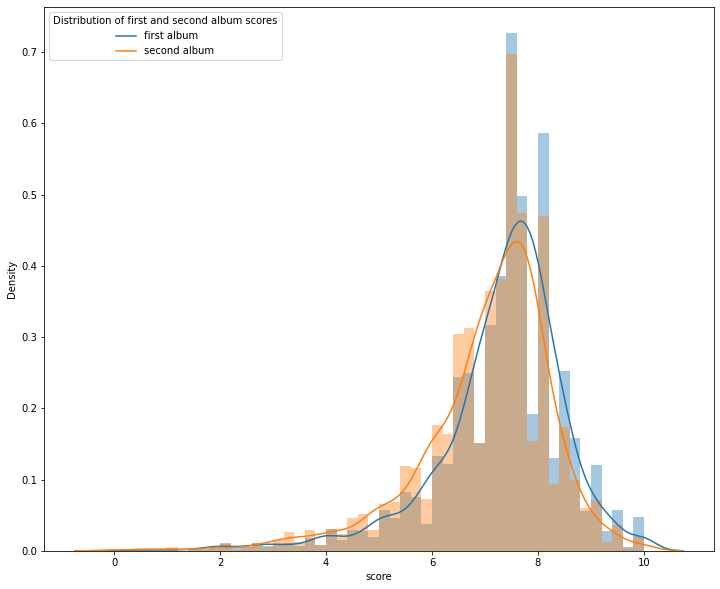

In [31]:
# 5.3 - Plot two distributions

fst = album_fst_snd[album_fst_snd.album_number == 0].sort_values(['artist'],ascending=True).reset_index(drop=True)
snd = album_fst_snd[album_fst_snd.album_number == 1].sort_values(['artist'],ascending=True).reset_index(drop=True)

# fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# fst_plot = sns.histplot(fst.score, bins=30, ax=axes[0])
# fst_plot.set_title('Distribution of score for the first album')
# fst_plot.set_yscale('log')

# snd_plot = sns.histplot(snd.score, bins=30, ax=axes[1])
# snd_plot.set_title('Distribution of score for the second album')
# snd_plot.set_yscale('log')


# Plot the distribution of score_first and score_second
plt.figure(figsize=[12,10])
sns.distplot(fst.score, hist=True, kde=True)
sns.distplot(snd.score, hist=True, kde=True)
plt.legend(title='Distribution of first and second album scores', loc='upper left', labels=['first album', 'second album'])
plt.show()

In [32]:
# 5.4

ttest_ind(fst.score, snd.score)

Ttest_indResult(statistic=8.903441019634498, pvalue=6.775768621491586e-19)

**Discussion 5.5**: Due to the fact that pvalue derived from ttest is significantly less than 0.05, thus we can say that there is a statistically significant difference between scores of first albums and second albums. Therefore, it is self-evident that the "second album syndrome" exists, which is also shown on the mean.

**Task 6 (Regression analysis — 20 pts)**

Next, you proceed to examine some hypotheses about the "second album syndrome" using a regression framework. Namely:

- The **time spent hypothesis:**  the first album usually has a couple of years of development under its belt and plenty of trial and error from live concerts to help the band determine what does or doesn't work. The second album, on the other hand, is often made in a rush.

- The **style change hypothesis:** bands often try to change their style after their first album. This change is not always welcomed by the listeners.

1. Create a new dataframe containing one row per 1st-2nd album pair. The dataframe should contain rows:
    - `score_diff`: the difference in scores between the second and the first album (second - first).
    - `time_diff`: the number of days elapsed between the first and the second album.
    - `did_style_change`: a dummy variable that indicates whether the style of the music has changed. To obtain it, first, calculate the [standardized euclidean distance](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.seuclidean.html) of music-related numerical features¹ between the second and the first album. Second, assign 1 to the 20% most distant 1st-2nd album pairs and 0 to all others.
2. Fit a linear regression using `statsmodels` with this dataframe. Your regression should consider only an intercept, i.e., `"score_diff ~ 1"`.
3. **Discuss:** Interpret the $R^2$ in your regression here. Does this analysis confirm what you observed in Task 5? Why?
4. Include the `time_diff` and `did_style_change` as covariates in your model. Fit the regression again and report the summary of your model. 
5. **Discuss:** Interpret the coefficients `time_diff` and `did_style_change`. Carefully explain whether they provide evidence towards each of the aforementioned hypotheses? Do they rule out other reasons that may cause the "second album syndrome effect"?
6. Create a new column called `time_diff_standardized`. It should be a standardized version of the `time_diff` column. Repeat the regression done in 6.4 using the `time_diff_standardized` column instead of the `time_diff` column.
7. **Discuss:** Explain how the interpretation of the coefficients associated with this new column `time_diff_standardized` differ from its non-standardized version 
`time_diff`?

--- 

**¹** Music related numerical features are:  "key", "acousticness", "danceability", "energy", "instrumentalness", "liveness", "loudness", "speechiness", "valence", and "tempo".


In [33]:
# 6.1 - Create a new dataframe

fst_snd_diff = pd.DataFrame()

fst_snd_diff["score_diff"] = snd.score - fst.score
fst_snd_diff["time_diff"]  = (snd.releaseyear - fst.releaseyear) * 365

music_features = ["key", "acousticness", "danceability", "energy", "instrumentalness",\
                  "liveness", "loudness", "speechiness", "valence", "tempo"]

# Compute the standardized euclidean distance of numerical music features
var = album_fst_snd[music_features].var(axis=0)

fst_snd_diff['did_style_change'] = \
pd.Series({row_idx: seuclidean(snd[music_features].iloc[row_idx], fst[music_features].iloc[row_idx], var) for row_idx in fst_snd_diff.index})

fst_snd_diff.head()

,score_diff,time_diff,did_style_change
0,1.0,1825.0,3.210281
1,0.2,730.0,1.836321
2,-0.1,730.0,2.758603
3,0.0,0.0,1.319840
4,-2.1,2190.0,2.610189


In [34]:
# 6.1 - Find the 20% most distant pairs and assign them to 1, else 0

threshold = fst_snd_diff['did_style_change'].quantile(0.8)

fst_snd_diff.did_style_change = fst_snd_diff.did_style_change.apply(lambda x: 0 if x <= threshold else 1)

fst_snd_diff.head(10)

,score_diff,time_diff,did_style_change
0,1.0,1825.0,0
1,0.2,730.0,0
2,-0.1,730.0,0
3,0.0,0.0,0
4,-2.1,2190.0,0
5,-0.2,1460.0,0
6,-3.2,730.0,1
7,1.7,365.0,0
8,-0.5,365.0,0
9,-0.8,730.0,0


In [35]:
# 6.2

# Fit a linear regression model by statsmodels
model = smf.ols(formula='score_diff ~ 1', data=fst_snd_diff)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             score_diff   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 26 Nov 2021   Prob (F-statistic):                nan
Time:                        01:02:46   Log-Likelihood:                -6197.0
No. Observations:                3564   AIC:                         1.240e+04
Df Residuals:                    3563   BIC:                         1.240e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2645      0.023    -11.468      0.000      -0.310      -0.219
==============================================================================
Omnibus:                      403.261   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2210.586
Skew:                          -0.397   Prob(JB):                         0.00
Kurtosis:                       6.776   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Discussion 6.3**: Here the $R^2$ is 0, this is because we only include the intercept, not considering the covariates. The intercept learned corresoponds to the expectation of $y$, which can be considered as $\overline{y}$. Thus according to the definition of $R^2$, $SS_{reg} = 0, SS_{tot} \not= 0, R^2 = \frac{SS_{reg}}{SS_{tot}} = 0$.

In [36]:
# 6.4 

# Include 'time_diff' & 'did_style_change' as covariates and fit the model again
model = smf.ols(formula='score_diff ~ time_diff + C(did_style_change)', data=fst_snd_diff)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             score_diff   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     31.73
Date:                Fri, 26 Nov 2021   Prob (F-statistic):           2.20e-14
Time:                        01:02:46   Log-Likelihood:                -6165.6
No. Observations:                3564   AIC:                         1.234e+04
Df Residuals:                    3561   BIC:                         1.236e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.1366      0.029     -4.648      0.000      -0.194      -0.079
C(did_style_change)[T.1]    -0.0592      0.057     -1.035      0.301      -0.171       0.053
time_diff                -8.843e-05   1.12e-05     -7.874      0.000      -0.000   -6.64e-05
==============================================================================
Omnibus:                      373.153   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2074.111
Skew:                          -0.338   Prob(JB):                         0.00
Kurtosis:                       6.676   Cond. No.                     6.20e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Discussion 6.5**: Here both covariates and the intercept have negative coefficients, which means they are negatively correlated to the album's expectation score difference. This provides evidence to the **style change hypothesis**: even if we only set 20% most distant as a "style" change, still this change shows a negative effect on the expected score, which means this change is not always welcomed by the listeners. But we need to re-analyze it through normalization over the 'time_diff' column, since the coefficient as well as the [0.025, 0.975] interval is too small to analyze properly. However, a negative trend on the this feature supports the hypothesis at first glance.

However, as for the **time spent hypothesis**, we cannot obtain direct inference for it because the model explains the correlation of score and time difference, without knowing the actual time artists used to produce their first album, we cannot compare whether the second album does take less time to produce.

In [37]:
# 6.6

# Create a new column 'time_diff_standardized' & re-fit the model by replacing 'time_diff' with this column

fst_snd_diff['time_diff_standardized'] = \
(fst_snd_diff.time_diff - fst_snd_diff.time_diff.mean()) / fst_snd_diff.time_diff.std()

display(fst_snd_diff.head())

model = smf.ols(formula='score_diff ~ time_diff_standardized + C(did_style_change)', data=fst_snd_diff)
res = model.fit()
res.summary()

,score_diff,time_diff,did_style_change,time_diff_standardized
0,1.0,1825.0,0,0.251453
1,0.2,730.0,0,-0.286039
2,-0.1,730.0,0,-0.286039
3,0.0,0.0,0,-0.644367
4,-2.1,2190.0,0,0.430617


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             score_diff   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     31.73
Date:                Fri, 26 Nov 2021   Prob (F-statistic):           2.20e-14
Time:                        01:02:47   Log-Likelihood:                -6165.6
No. Observations:                3564   AIC:                         1.234e+04
Df Residuals:                    3561   BIC:                         1.236e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -0.2527      0.026     -9.881      0.000      -0.303      -0.203
C(did_style_change)[T.1]    -0.0592      0.057     -1.035      0.301      -0.171       0.053
time_diff_standardized      -0.1802      0.023     -7.874      0.000      -0.225      -0.135
==============================================================================
Omnibus:                      373.153   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2074.111
Skew:                          -0.338   Prob(JB):                         0.00
Kurtosis:                       6.676   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Discussion 6.7**: After normalization, we could see clearly that time difference do correlate negatively to the expected score in the regression model. Before normalization, the value in 'time_diff' varies greatly and its scale significantly exceeds the 'did_style_change' feature as well as the expected score difference, this will result in the trained coefficient of 'time_diff' having a very small value. It means the expected score will decrease by that coefficient value for a one-day time difference. The normalized version of time difference 'time_diff_standardized', reshaped the time difference distribution to a $\mu=0,\sigma=1$ normal distribution. Here the coefficient for this feature represents an overall impact(or trend) of time difference on the expected score difference, being negatively correlated.

**Task 7 (Sanity checks — 6 pts)**

You decide to perform a few last sanity checks for your analysis.

1.  **Discuss:** If the Second Album Syndrome existed, i.e., something was special about the second album (as in if it was bad for a very particular reason that afflicted album number 2 more than all others), what would you expect to happen to the mean score of the third album?
2. Using the dataset you created in Task 5, calculate the mean and the standard error of the mean for the 1st, 2nd, 3rd, and 4th albums. Test whether the difference between the average score of the second and the third album is statistically significant.
3. **Discuss:** Does this suggest that the Second Album Syndrome exists?

---


**Diccussion 7.1**: Given that the Second Album Syndrome existed, I would expect a bottoming out for the mean score of the third album. That is, the mean score of the third album would be higher than the second album.

In [38]:
# 7.2

# Case 1: Consider all the artists, no matter how many albums they have produced
stats_all_album = df[df.album_number <= 3].groupby("album_number").agg({'score':['sem','mean', 'count']})

print("Case 1: Statistics for all the artists")
display(stats_all_album)

# Case 2: Consider artists who have produced >= 4 albums
artists_4_album = df.groupby('artist')\
                    .filter(lambda x : x['album_number'].shape[0] > 3)\
                    .sort_values(by=['artist', 'album_number'], ascending=False)

stats_4_album = artists_4_album[artists_4_album.album_number <= 3]\
                               .groupby("album_number")\
                               .agg({'score':['sem','mean', 'count']})

print("Case 2: Statistics for artists with >= 4 albums")
display(stats_4_album)

Case 1: Statistics for all the artists


score                
                   sem      mean count
album_number                          
0             0.020686  7.303002  3564
1             0.021327  7.038468  3564
2             0.027617  7.044410  1950
3             0.036123  7.040662  1178

Case 2: Statistics for artists with >= 4 albums


score                
                   sem      mean count
album_number                          
0             0.039169  7.541851  1178
1             0.038313  7.343803  1178
2             0.036308  7.163837  1178
3             0.036123  7.040662  1178

In [39]:
# 7.2 - Case 1 result

ttest_ind(df[df['album_number'] == 1]['score'], df[df['album_number'] == 2]['score'])

Ttest_indResult(statistic=-0.16816255372281083, pvalue=0.8664615688260937)

In [40]:
# 7.2 - Case 2 result

ttest_ind(artists_4_album[artists_4_album['album_number'] == 1]['score'],\
          artists_4_album[artists_4_album['album_number'] == 2]['score'])

Ttest_indResult(statistic=3.409461292315207, pvalue=0.000661878213845686)

In this task, we are analysing the mean and the standard error of the mean for the 1st, 2nd, 3rd, and 4th albums in two cases:
1. Consider all artists no matter how many albums they have produced
2. Consider only artists with >= 4 albums

T-test on the two aforementioned cases gives quite different pvalue outcomes. That is, pvalue for case 1 (0.86646) indicates no statistically significant difference between the score of the second album and the thrid album. For case 2, the outcome pvalue (0.00066) indicates there is a statistically significant difference between the score of second and third album.

**Discussion 7.3**:
Here, we would more to discuss on case 2, and the reasons why we chose case 2 are listed as follows:
* The size of rows taken to calculate means varies in case 1: 3564 artists produced 2 albums and 1950 artists produced 3 albums, this might be due to the music company is not optimistic about the market return for those artists, thus is not willing to make albums any more. One supporting evidence for this reason is that the mean of scores for first, second and third album in case 2 are moderately higher than that of case 1.
* It makes more sense to decide whether the Second Album Syndrome exists based on the albums produced by the same artists, so that we can mitigate the impact of **unobserved covariates**.

Although there is a statistically significant difference between the score of second and thrid album, the mean score of the second album is however much higher than the third album, which means the Second Album Syndrome **does not exist**.

**Task 8 (Eureka — 14 pts)**

Your boss, *Signor Piccardi*, proposes that you carry out a simulation to make things clearer. Assuming that:


- Each band $i$ has a "talent" $\mu_i$ , which is uniformally distributed between 2 and 8, i.e., $\mu_i \sim U_{[2,8]}$.
- When a band $i$ produces an album $j$, it has quality $s_j$. This score is normally distributed with mean $\mu_i$ and standard deviation $1$, i.e., $s_j \sim N(\mu_i, 1)$
- Talents are independent and identically distributed random variables.
 
Carry out the following simulation:

- Create 1000 hypothetical bands with intrinsic talents $\mu_i \sim U_{[2,8]}$ for $i \in [1,1000]$.
- Have each hypothetical band create a hypothetical album.
- Discard all bands whose albums received a score smaller than 6.
- For each of the remaining bands, create two additional albums.

Analyzing the scores obtained in this simulation, provide a coherent explanation for the  scores obtained in Task 7.2. 

--- 

**Hint:** You can use numpy to sample random variables (e.g. [numpy.random.normal](https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html))

In [41]:
# Create hypothetical bands with interinsic talents 
simulation = pd.DataFrame({'band':np.arange(0,1000), 'talent':np.random.uniform(low=2,high=8,size=1000)})

# Have each hypothetical band create a hypothetical album, represented by its quality score
simulation["album1_quality"] = simulation.talent.apply(lambda x: float(np.random.normal(loc=x, scale=1, size=1)))

# Preserve all bands whose albums received a score greater than or equals to 6
simulation = simulation[simulation.album1_quality >= 6]

# For each of the remaining bands, create two additional albums
for i in range(2,4):
    simulation["album{}_quality".format(i)] = simulation.talent.apply(lambda x: float(np.random.normal(loc=x, scale=1, size=1)))

simulation.head()

,band,talent,album1_quality,album2_quality,album3_quality
0,0,7.626962,8.114039,8.033460,8.566341
4,4,7.196605,6.754056,7.473583,5.160666
5,5,7.530198,7.765459,9.003081,7.282161
7,7,7.030819,7.292503,7.471528,6.848699
8,8,7.209419,8.277421,5.411065,7.414813


In [42]:
# Conduct the same analysis as Task 7.2

stats_simu = simulation.agg({'album1_quality':['sem','mean'], 'album2_quality':['sem', 'mean'], 'album3_quality':['sem', 'mean']})
display(stats_simu)

ttest_ind(simulation['album2_quality'], simulation['album3_quality'])

,album1_quality,album2_quality,album3_quality
sem,0.048968,0.070761,0.072248
mean,7.207472,6.707776,6.664506


Ttest_indResult(statistic=0.4278697431013712, pvalue=0.6688810308966031)

The pvalue suggests that the Second Album Syndrome does not exists in the simulation, the explanation for this result is that the quality scores generated for album 2 and album 3 are solely dependent on the talent of the bank, album 2 quality score neither not have any causal effect on the quality of album 3, nor does these two albums have any dependencies on any unobserved variates. 

However, we do believe that in real life, the quality score for an album have more complicated causality. As can be seen from table for case 2 in task 7.2, the mean of scores for albums is gradually decreased. This might be because albums produced by the same artist is more and more unoriginal, which implies there exists a causal effect from the previous album to the new album. Besides, although we have mitigated the impact of unobserved variates, there are still some unobserved variates that take effect, e.g. music preference over time.

